## Electric Vehicle Market Segmentation Analysis

### Importing Necessary Libraries

In [1]:
# for data manipulation and analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# for feature decomposition
from sklearn.decomposition import PCA

# for clustering
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

# for data pre proprecessing
import nltk
import missingno as msno
from bioinfokit.visuz import cluster
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from nltk.sentiment import SentimentIntensityAnalyzer
from statsmodels.graphics.mosaicplot import mosaic
from itertools import product

# warnings filtering
import warnings
warnings.filterwarnings('ignore')

### Loading Data

#### Sales Data
- This data has sales of electric two-wheelers, three-wheelers, four-wheelers, and buses spanning 2017 to 2023. This dataset provides a comprehensive view of market trends and customer preferences over time.

In [2]:
sales = pd.read_excel('sales_data.xlsx', sheet_name=None)

In [3]:
sales.keys()

dict_keys(['EV 2W FY 19-20', 'EV 2W FY 20-21', 'EV 2W FY 21-22', 'EV 2W FY 22-23', 'EV Market', 'Electric Bus Sales', 'Electric 4-Wheeler Sales', 'Electric 3-Wheeler Sales', 'Electric 2-Wheeler Sales', 'EV Industries'])

In [4]:
sales['EV Industries']

,category,financial_year,num_vehicles
0,E-2 Wheelers,2017-18,1981
1,E-2 Wheelers,2018-19,27478
2,E-2 Wheelers,2019-20,26512
3,E-2 Wheelers,2020-21,44294
4,E-2 Wheelers,2021-22,249615
5,E-2 Wheelers,2022-23,728090
6,E-3 Wheelers,2017-18,91970
7,E-3 Wheelers,2018-19,116031
8,E-3 Wheelers,2019-20,143051
9,E-3 Wheelers,2020-21,90898


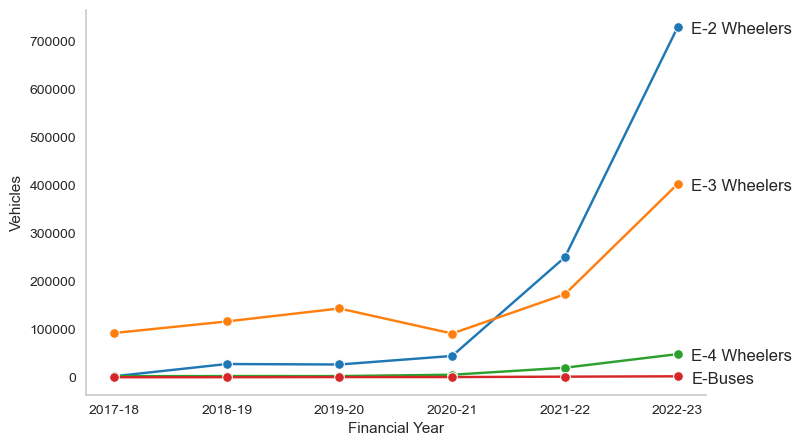

In [5]:
plt.figure(figsize = (8,5))
ax = sns.lineplot(data=sales['EV Industries'], x='financial_year', y='num_vehicles', hue='category', marker='o', palette='tab10')
plt.xlabel("Financial Year")
plt.ylabel("Vehicles")
plt.legend(title='Category')

# Annotate the last data point
for col in sales['EV Industries']['category'].unique():
    last_point = sales['EV Industries'][sales['EV Industries']['category'] == col].iloc[-1]
    plt.annotate(f"{last_point['category']}", 
                 (last_point['financial_year'], last_point['num_vehicles']),
                 textcoords="offset points",
                 xytext=(10, -5), 
                 ha='left')
sns.despine()
ax.get_legend().set_visible(False)
plt.grid(False)
plt.show()

- Above Figure shows the notable growth of India's two-wheeler market in 2023,highlighting its leading position within the industry.

In [6]:
category = sales['EV Market'].sort_values('Amount INR Cr', ascending = False)

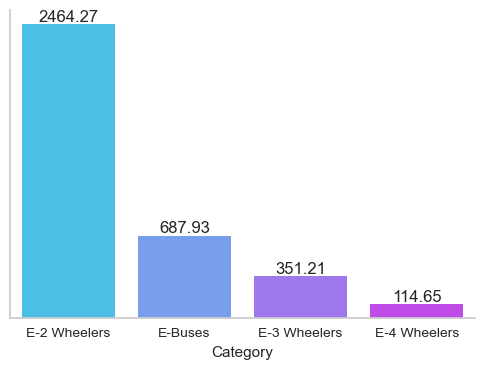

In [7]:
plt.figure(figsize = (6,4))
y = sns.barplot(data = category,x = category['Category'],y = category['Amount INR Cr'],palette = 'cool')
y.bar_label(y.containers[0])
sns.despine()
plt.yticks([])
plt.ylabel("")
plt.grid(False)
plt.show()

- Above Figure shows revenue generated by each EV industry in crores,we notice that two-wheelers emeeged as the primary revenue generators, highlighting their economic significance.

In [8]:
ev_sales_data= list(sales.keys())[0:4]
ev_data = pd.concat([sales[ev_sales_data[0]], sales[ev_sales_data[1]], sales[ev_sales_data[2]], sales[ev_sales_data[3]]])

In [9]:
ev_data['maker'] = ev_data['maker'].str.upper()
np.sort(ev_data['maker'].unique())

array(['AMPERE', 'AMPERE VEHICLES', 'ATHER', 'ATHER ENERGY', 'BAJAJ',
       'BEING INDIA', 'BENLING', 'HERO ELECTRIC', 'JITENDRA',
       'JITENDRA NEW EV', 'OKAYA EV', 'OKINAWA', 'OKINAWA AUTOTECH',
       'OLA ELECTRIC', 'OTHERS', 'PURE EV', 'REVOLT', 'TVS'], dtype=object)

In [10]:
ev_data['maker'] = ev_data['maker'].replace(['AMPERE VEHICLES','ATHER ENERGY','BEING INDIA','JITENDRA NEW EV','OKINAWA AUTOTECH'], ['AMPERE','ATHER','BENLING','JITENDRA','OKINAWA'])
ev_data_year = ev_data.groupby(['financial_year', 'maker']).agg({'num_vehicles':'sum'}).reset_index()

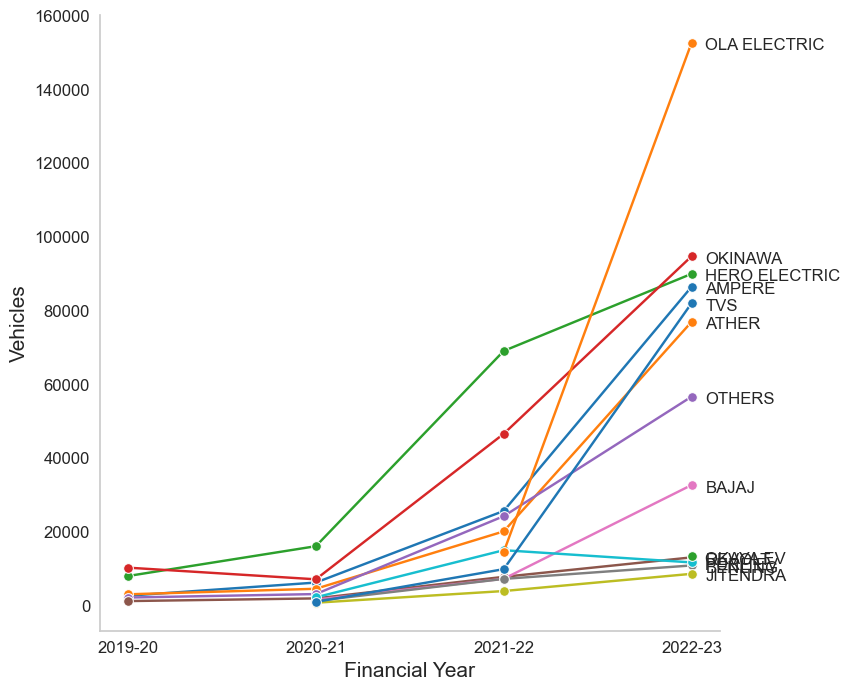

In [11]:
plt.figure(figsize = (8,8))
ax = sns.lineplot(data=ev_data_year, x='financial_year', y='num_vehicles', hue='maker', marker='o', palette='tab10')
plt.xlabel("Financial Year", fontsize = 15)
plt.ylabel("Vehicles", fontsize = 15)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.legend(title='Maker')

# Annotate the last data point
for col in ev_data_year['maker'].unique()[::1]:
    last_point = ev_data_year[ev_data_year['maker'] == col].iloc[-1]
    plt.annotate(f"{last_point['maker']}", 
                 (last_point['financial_year'], last_point['num_vehicles']),
                 textcoords="offset points",
                 xytext=(10, -5), 
                 ha='left')
sns.despine()
ax.get_legend().set_visible(False)
plt.grid(False)
plt.show()

- Above Figure shows specific electric two-wheeler companies, with Ola Electric emerging as the market leader in 2023, illustrating industry leadership and market competitiveness.

## EV Market Segmentation

* The dataset used for the market segmentation analysis is extracted from bikewale.com, comprises electric two-wheeler customer reviews, offering vital behavioral and psychographic insights.
* It also presents detailed technical specifications and pricing information of electric two-wheelers. This data allowed us to assess the technical feasibility and price points crucial for our market segmentation strategy.

In [12]:
df1 = pd.read_csv('ev_2_bikewale_reviews.csv')
df2 = pd.read_csv('ev_model_spec.csv')
df = df1.merge(df2, how = 'left', on = 'Model Name')
df.head()

,review,Used it for,Owned for,Ridden for,rating,Visual Appeal,Reliability,Performance,Service Experience,Extra Features,Comfort,Maintenance cost,Value for Money,Model Name,Price,Riding Range (km),Top Speed (kmph),Weight (kg),Battery Charging Time (hrs),Rated Power (W)
0,We all checked the bike's capacity to be 150 k...,Daily Commute,Never owned,NaN,1,3.0,4.0,NaN,NaN,NaN,4.0,NaN,1.0,TVS iQube,137890,100,78,117,5,3000
1,Performance is very poor on this bike. The cha...,Everything,> 1 yr,< 5000 kms,1,3.0,1.0,NaN,1.0,NaN,3.0,NaN,3.0,TVS iQube,137890,100,78,117,5,3000
2,I purchased this in April 2022 and the sales s...,Daily Commute,< 3 months,< 5000 kms,3,4.0,4.0,NaN,2.0,NaN,5.0,NaN,2.0,TVS iQube,137890,100,78,117,5,3000
3,If any issues come in scooty parts not availab...,Daily Commute,6 months-1 yr,5000-10000 kms,1,1.0,1.0,NaN,1.0,NaN,1.0,NaN,1.0,TVS iQube,137890,100,78,117,5,3000
4,Don't buy this vehicle unless you have a near ...,Daily Commute,6 months-1 yr,< 5000 kms,1,3.0,4.0,NaN,1.0,NaN,3.0,NaN,2.0,TVS iQube,137890,100,78,117,5,3000


<AxesSubplot:>

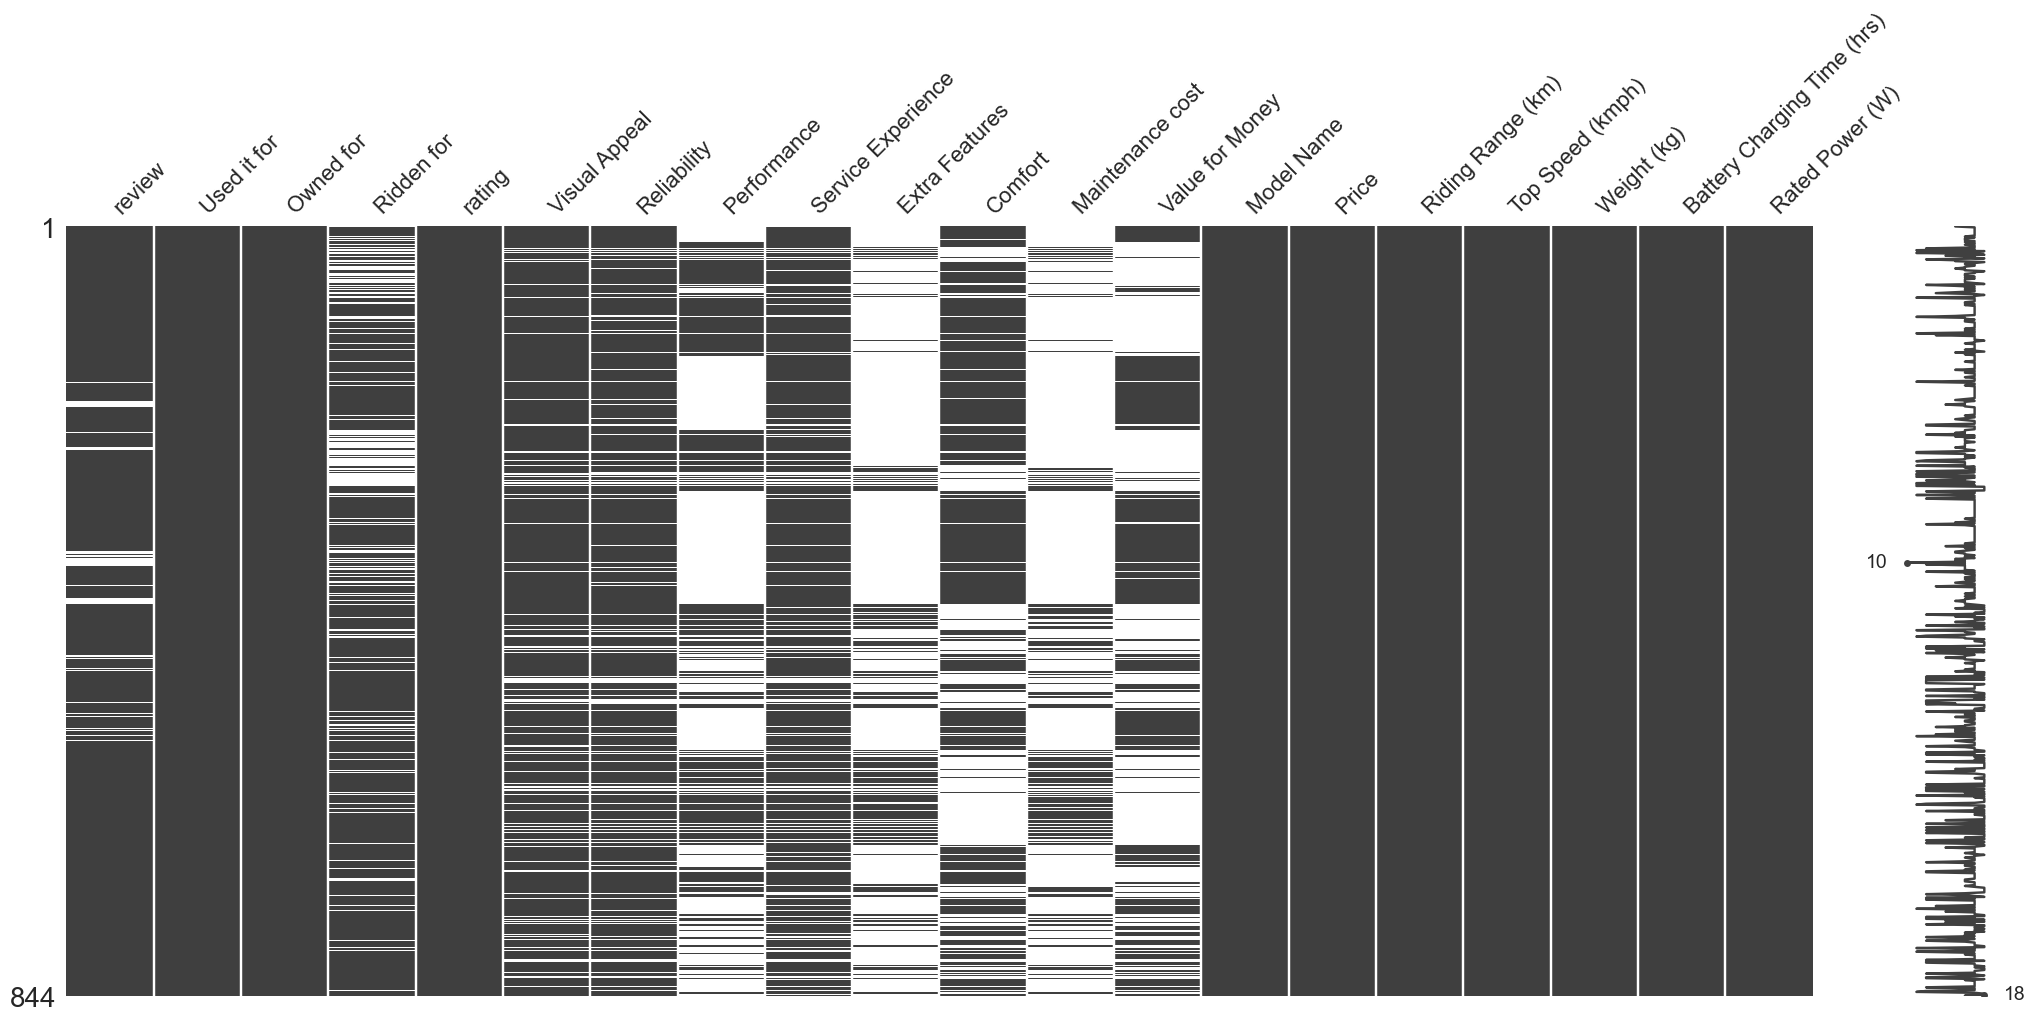

In [13]:
msno.matrix(df)

### Data Preprocessing

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 844 entries, 0 to 843
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   review                       797 non-null    object 
 1   Used it for                  844 non-null    object 
 2   Owned for                    844 non-null    object 
 3   Ridden for                   668 non-null    object 
 4   rating                       844 non-null    int64  
 5   Visual Appeal                739 non-null    float64
 6   Reliability                  716 non-null    float64
 7   Performance                  345 non-null    float64
 8   Service Experience           703 non-null    float64
 9   Extra Features               185 non-null    float64
 10  Comfort                      530 non-null    float64
 11  Maintenance cost             180 non-null    float64
 12  Value for Money              390 non-null    float64
 13  Model Name          

In [15]:
sentiments = SentimentIntensityAnalyzer()
sentiments_list = []

for review_text in df['review']:
    if pd.isna(review_text):
        sentiments_list.append('neutral')
        continue
    sentiment_scores = sentiments.polarity_scores(review_text)

    positive_score = sentiment_scores['pos']
    negative_score = sentiment_scores['neg']

    if positive_score > negative_score:
        sentiment_label = 'positive'
    elif positive_score < negative_score:
        sentiment_label = 'negative'
    else:
        sentiment_label = 'neutral'

    sentiments_list.append(sentiment_label)
    
df['sentiment'] = sentiments_list

In [16]:
df['sentiment'].value_counts()

positive    527
negative    264
neutral      53
Name: sentiment, dtype: int64

In [17]:
data_segment = df[['Used it for', 'Owned for', 'Ridden for', 'rating',
       'Visual Appeal', 'Reliability', 'Performance', 'Service Experience',
       'Extra Features', 'Comfort', 'Maintenance cost', 'Value for Money',
       'sentiment']].copy()
data_segment.head()

,Used it for,Owned for,Ridden for,rating,Visual Appeal,Reliability,Performance,Service Experience,Extra Features,Comfort,Maintenance cost,Value for Money,sentiment
0,Daily Commute,Never owned,NaN,1,3.0,4.0,NaN,NaN,NaN,4.0,NaN,1.0,negative
1,Everything,> 1 yr,< 5000 kms,1,3.0,1.0,NaN,1.0,NaN,3.0,NaN,3.0,negative
2,Daily Commute,< 3 months,< 5000 kms,3,4.0,4.0,NaN,2.0,NaN,5.0,NaN,2.0,positive
3,Daily Commute,6 months-1 yr,5000-10000 kms,1,1.0,1.0,NaN,1.0,NaN,1.0,NaN,1.0,negative
4,Daily Commute,6 months-1 yr,< 5000 kms,1,3.0,4.0,NaN,1.0,NaN,3.0,NaN,2.0,negative


### Treating null values

In [18]:
data_segment = df.iloc[:, 5:13].copy()
data_segment = data_segment.fillna(0.)

### Normalizing

In [19]:
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_segment)

### Principal component analysis

In [20]:
pca = PCA(random_state = 42)
pca.fit(data_scaled)
data_pca = pca.transform(data_scaled)
df_pca = pd.DataFrame(data_pca, columns = [f'PC{x +1}' for x in range(len(data_segment.columns))])
df_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8
0,0.291227,-1.038055,0.354864,-0.623469,-1.102720,-0.169287,-0.438012,0.957827
1,0.710801,-1.394405,-0.360466,-0.621671,0.320899,-0.086053,-0.426279,-0.149917
2,-0.849149,-1.189765,0.167683,-0.410898,-0.409054,-0.191904,-0.329993,0.830738
3,1.967022,-0.878935,-0.100197,0.330003,-0.075822,0.069599,0.013068,0.011328
4,0.078940,-1.017161,-0.079210,-0.324132,-0.961554,0.005517,-0.107260,0.427972


In [21]:
pca_summary = pd.DataFrame({'Standard Deviation':df_pca.std(),
                           'Proportion of Variance': pca.explained_variance_ratio_,
                           'Cumultive Proportion': pca.explained_variance_ratio_.cumsum()})
pca_summary

,Standard Deviation,Proportion of Variance,Cumultive Proportion
PC1,1.845017,0.425007,0.425007
PC2,1.736646,0.376546,0.801553
PC3,0.903486,0.101915,0.903468
PC4,0.517750,0.033468,0.936936
PC5,0.405239,0.020503,0.957439
PC6,0.379558,0.017987,0.975426
PC7,0.337883,0.014254,0.989680
PC8,0.287510,0.010320,1.000000


### Correlation matrix plot for loadings 

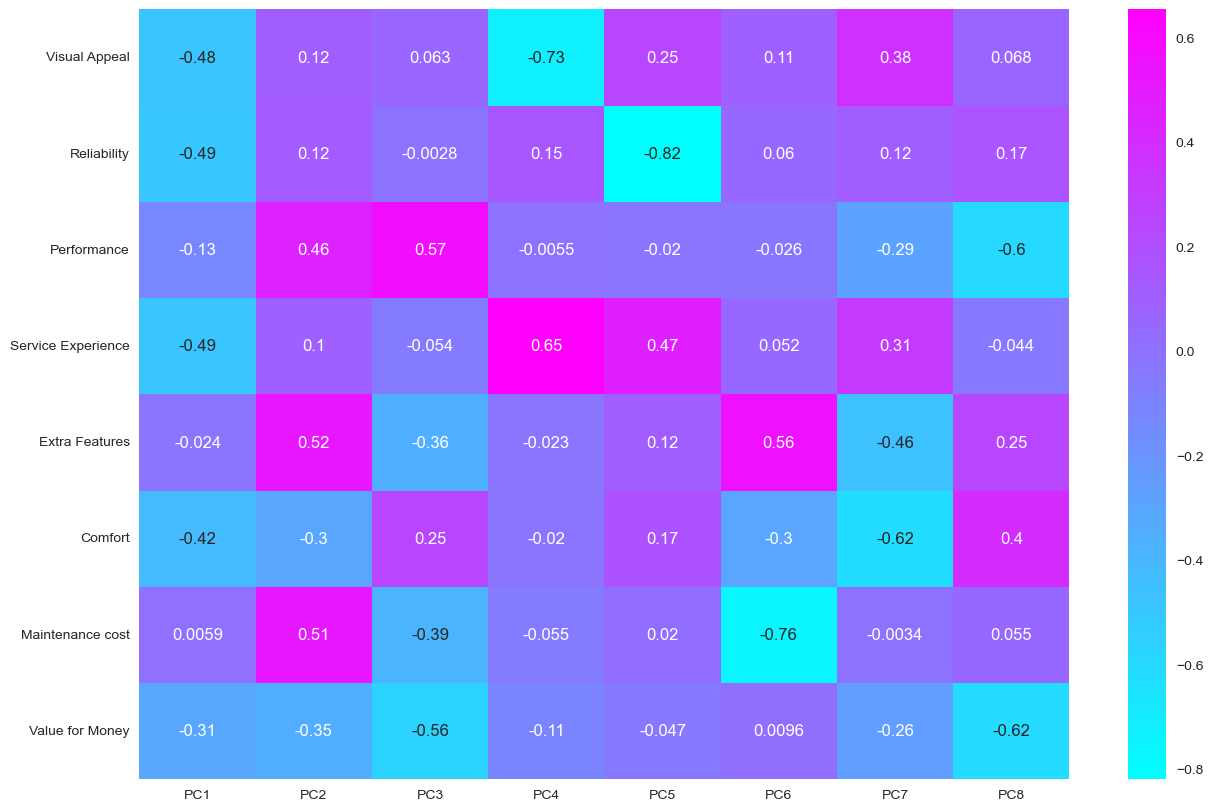

In [22]:
factor_loadings = pd.DataFrame(pca.components_, columns = data_segment.columns, index = df_pca.columns).T
plt.figure(figsize = (15,10))
sns.heatmap(factor_loadings, annot=True, cmap='cool')
plt.show()

### Get 2D biplot

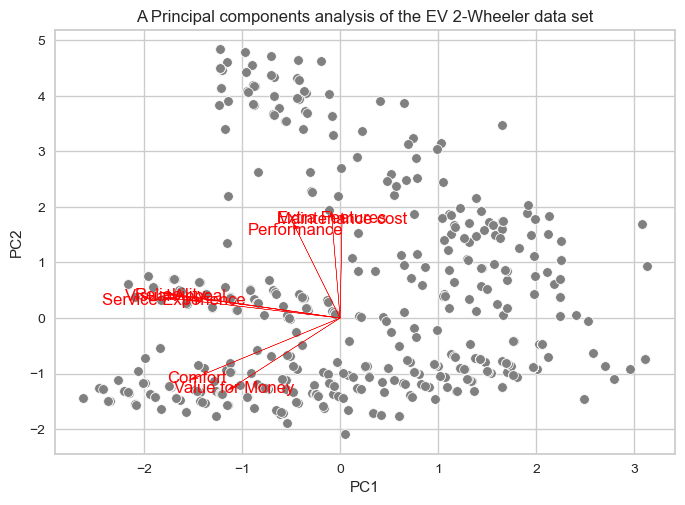

In [23]:
# Calculate centroid
index_names = factor_loadings.index

# Plot data points
sns.scatterplot(data = df_pca, x = 'PC1', y = 'PC2', color = 'grey')

# Plot arrows from centroid to provided coordinates with index names
for i in range(len(factor_loadings['PC1'])):
    plt.arrow(0, 0, factor_loadings['PC1'][i] * 3.5, factor_loadings['PC2'][i] * 3.5, head_width=0.05, head_length=0.1, fc='red', ec='red')
    plt.text((factor_loadings['PC1'][i] * 3.5), factor_loadings['PC2'][i]* 3.5, index_names[i], fontsize=12, ha='center', color = 'red', va = 'center_baseline')

# Set labels and legend
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('A Principal components analysis of the EV 2-Wheeler data set')
plt.grid(True)
plt.show()

## Extracting Segments

KElbowVisualizer(ax=<AxesSubplot:>, estimator=KMeans(n_clusters=11), k=(1, 12))

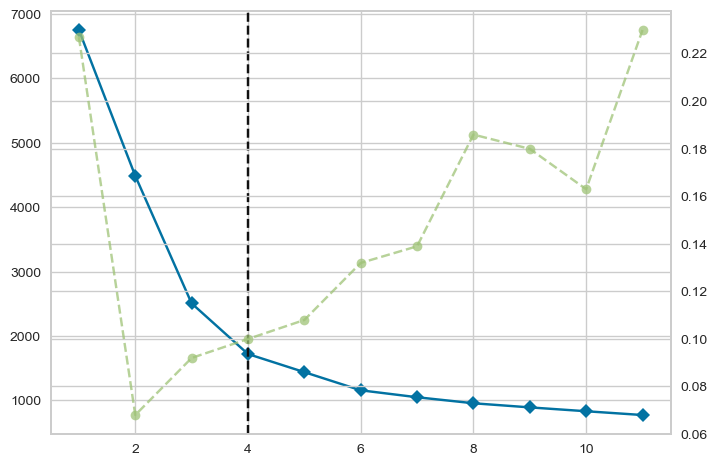

In [24]:
KElbowVisualizer(KMeans(), k=(1,12)).fit(data_scaled)

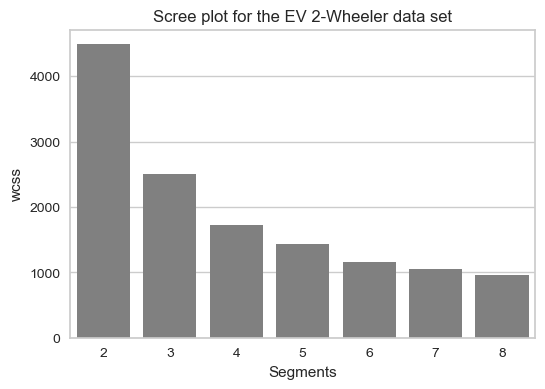

In [25]:
kmeans_data = [KMeans(n_clusters = k, random_state = 42).fit(data_scaled) for k in range(2, 9)]
wcss = [model.inertia_ for model in kmeans_data]
plt.figure(figsize = (6,4))
sns.barplot(x = list(range(2, 9)), y = wcss, color = 'grey')
plt.xlabel("Segments")
plt.ylabel('wcss')
plt.title("Scree plot for the EV 2-Wheeler data set")
plt.show()

- Above both plots revealing a distinct elbow at four segments. signifying the optimal number of segments for our analysis

In [26]:
kmeans = kmeans_data[2]
cluster_df = pd.DataFrame(data_scaled, columns = data_segment.columns)
cluster_df['cluster'] = kmeans.labels_

In [27]:
data_pca = df_pca.copy()
data_pca['cluster'] = kmeans.labels_

## Profiling Segments

In [28]:
data_profile = data_segment.copy()
data_profile['cluster'] = kmeans.labels_
columns_segment = cluster_df.columns
data_pivot = data_profile[columns_segment].groupby('cluster').mean().T

In [29]:
data_pivot_mean = data_pivot.mean(axis = 1).reset_index()
data_pivot_mean.columns = ['Variable', 'Value']

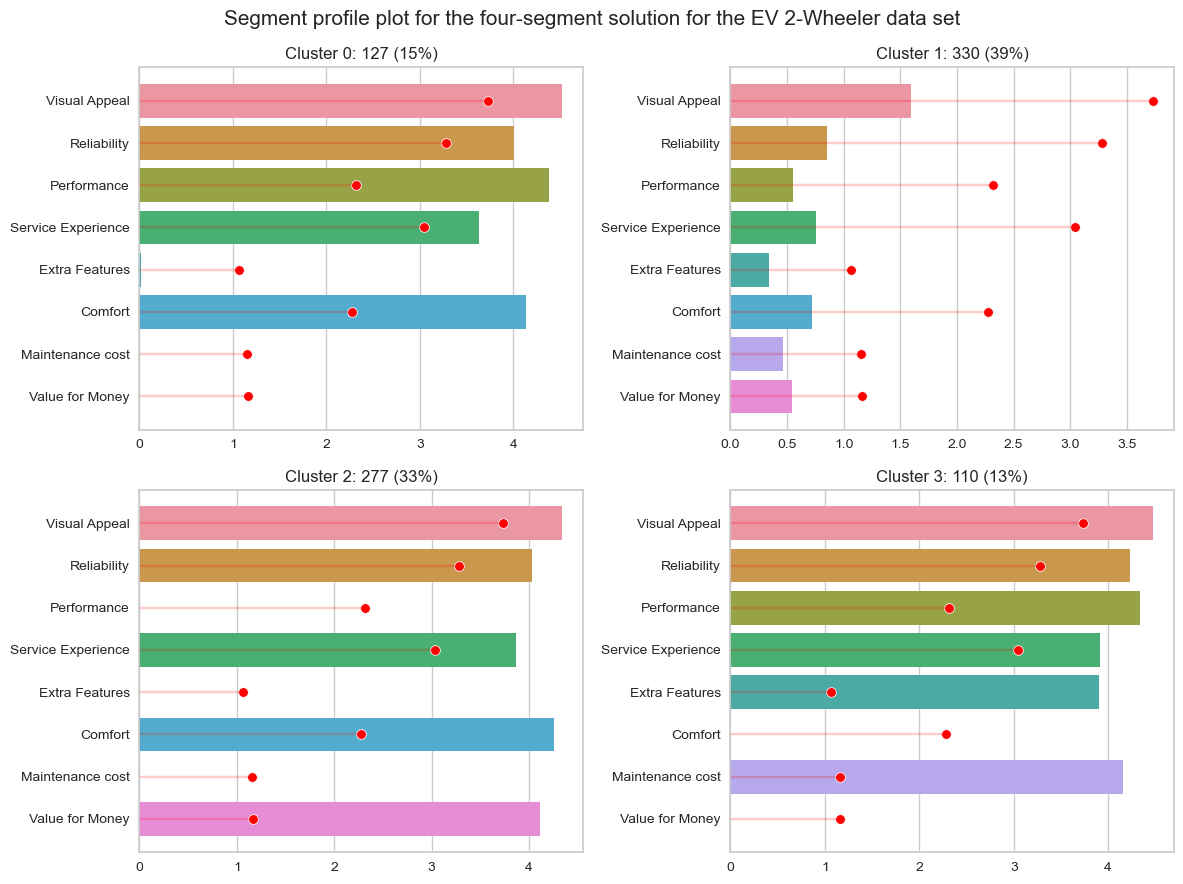

In [30]:
plt.figure(figsize = (12, 9))
for i in range(4):
    plt.subplot(2, 2, i+1)
    sns.barplot(data = data_pivot, x = i, y = data_pivot.index)
    sns.scatterplot(data = data_pivot_mean, x = 'Value', y = 'Variable', color = 'red')
    for index, row in data_pivot_mean.iterrows():
        plt.hlines(y=row['Variable'], xmin=0, xmax=row['Value'], colors='red', alpha = 0.2)
    plt.ylabel("")
    plt.xlabel("")
    plt.title(f"Cluster {i}: {data_profile['cluster'].value_counts()[i]} ({data_profile['cluster'].value_counts()[i]*100/len(data_profile):.0f}%)")
plt.suptitle("Segment profile plot for the four-segment solution for the EV 2-Wheeler data set", fontsize = 15)
plt.tight_layout()
plt.show()

Above graph visually captures the diverse perceptions among different segments. 
- Segment 0, representing 15% of consumers, values the electric two-wheeler vehicle for its visual appeal, reliability, performance, service experience, and comfort. 
- Conversely, Segment 1 (39% of consumers) expresses dissatisfaction across all aspects, marking them as the largest but least satisfied group. 
- Segment 2 (33% of consumers) appreciates visual appeal, reliability, service experience, comfort, and notably, perceives a strong value for money.
- Lastly, Segment 3 (13% of consumers), the smallest segment, values visual appeal, reliability, performance, service experience, extra features, and maintenance cost, showcasing distinct perceptions, particularly on features and costs.

## Describing Segments

In [31]:
data_desc = df.copy()
data_desc['cluster'] = kmeans.labels_

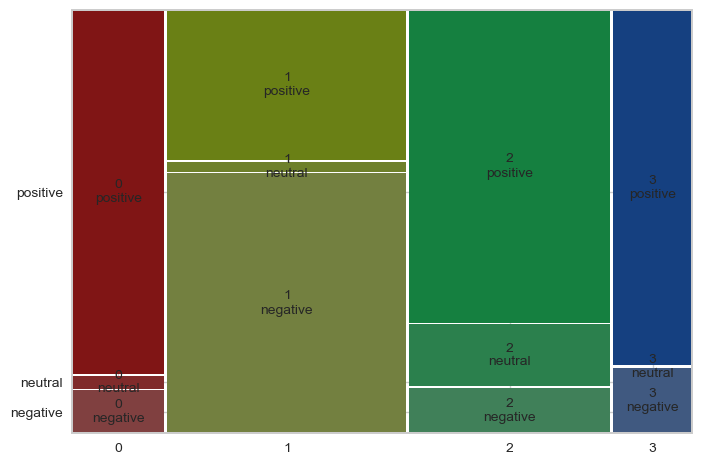

In [32]:
mosaic(pd.crosstab(data_desc['cluster'],data_desc['sentiment']).stack())
plt.show()

- Above mosaic plot, explores consumer sentiments, revealing that all segments, except Segment 1, exhibit positive sentiments. 
- Segment 1 consumers stand out with negative sentiments, indicating dissatisfaction across various aspects.

<Figure size 800x1500 with 0 Axes>

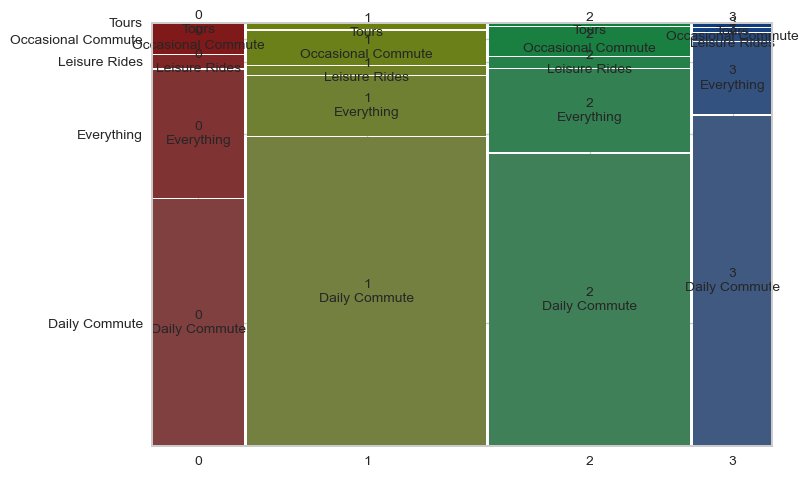

In [34]:
mosaic(pd.crosstab(data_desc['cluster'],data_desc['Used it for']).stack())
plt.show()

- Above mosaic plot illustrates that all segments predominantly use electric vehicles for daily commuting, with limited usage for tours, occasional commuting, and leisure rides.

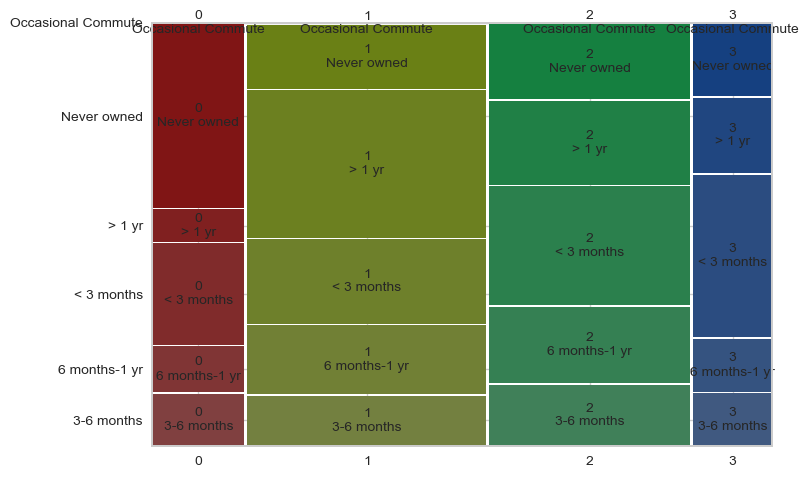

In [37]:
mosaic(pd.crosstab(data_desc['cluster'],data_desc['Owned for']).stack())
plt.show()

Above mosaic plot shows the ownership duration of electric vehicles among segments. 
- Segment 0 has no prior ownership experience. 
- Segment 1 stands out, owning electric vehicles for more than a year,
- Segment 2 members moderately own vehicles ranging from less than 3 months to over a year
- Segment 3 consumers have owned electric vehicles for a few days to less than 3 months.

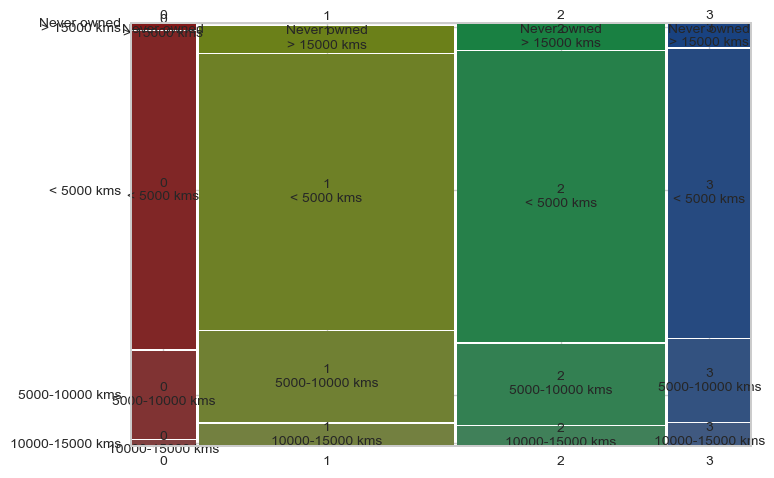

In [38]:
mosaic(pd.crosstab(data_desc['cluster'],data_desc['Ridden for']).stack())
plt.show()

Above mosaic plot shows the distances covered by consumers
- All segments predominantly use electric vehicles for commuting, with most users covering distances below 5000 kms.
- A small portion falls in the 5000 to 10000 kms range, aligning with their commuting needs.

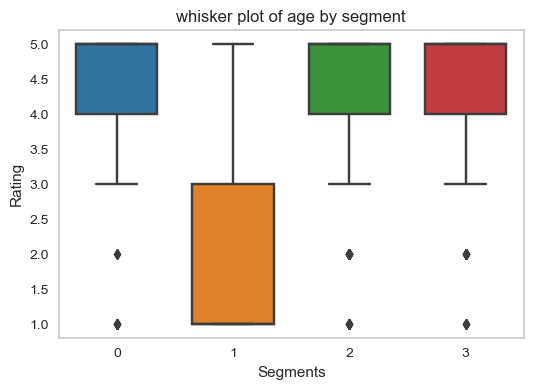

In [41]:
# Number of cluster along the x-axis and rating along the y-axis
plt.figure(figsize = (6,4))
sns.boxplot(data = data_desc, x= 'cluster', y = 'rating', palette = 'tab10', width = 0.7)
plt.xlabel("Segments")
plt.ylabel("Rating")
plt.title("whisker plot of age by segment")
plt.grid(False)
plt.show()

- Above whisker plot, shows significant differences in average ratings among segments. Specifically, Segment 1 consumers express dissatisfaction across all perceptions, leading to lower overall ratings.

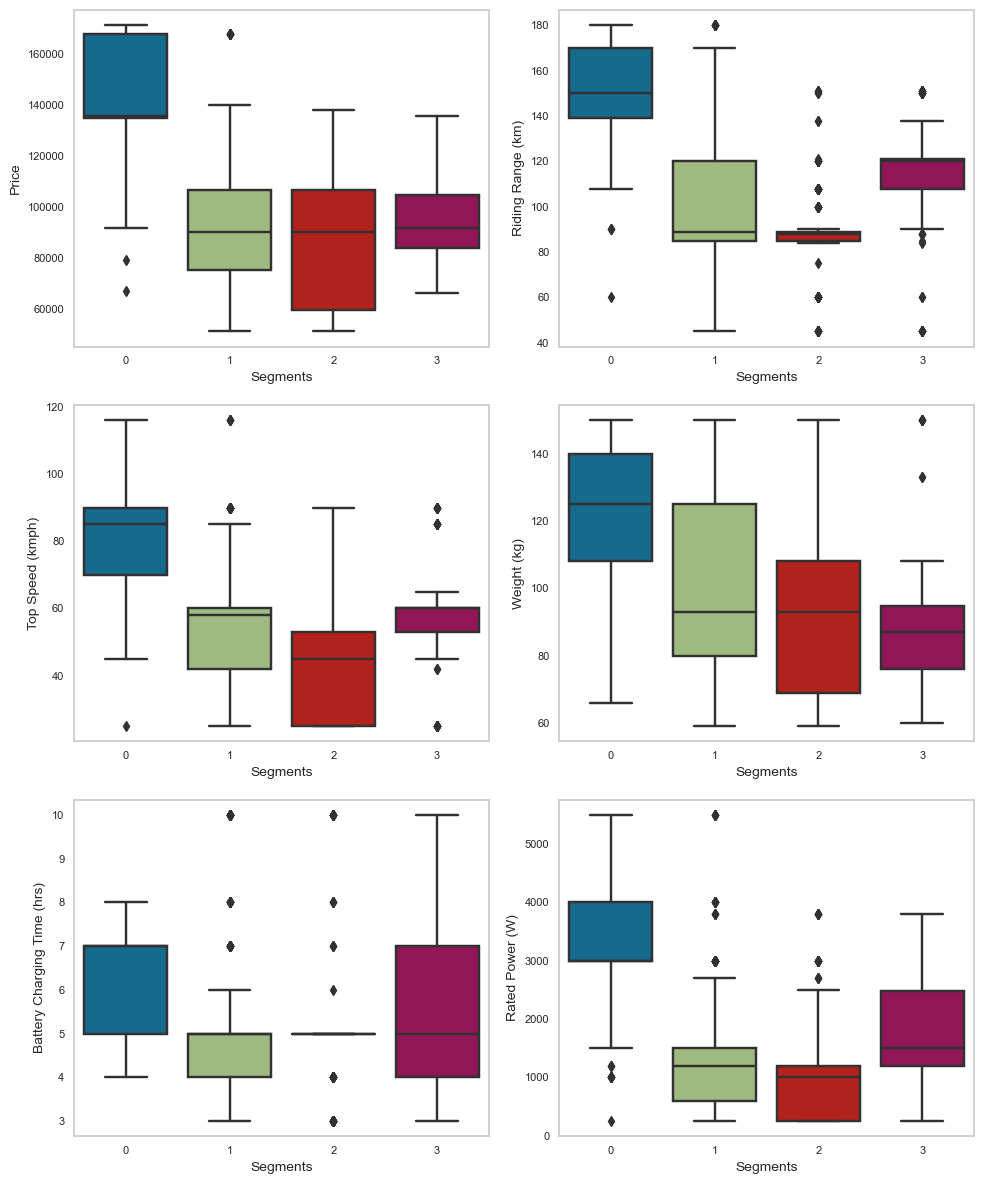

In [47]:
plt.figure(figsize = (10, 12))
for i, col in enumerate(data_desc.columns[-8:-2]):
    plt.subplot(3, 2, i+1)
    sns.boxplot(data = data_desc, x = 'cluster', y =col)
    plt.xlabel("Segments", fontsize= 10)
    plt.ylabel(col, fontsize = 10)
    plt.xticks(fontsize = 8)
    plt.yticks(fontsize = 8)
    plt.grid(False)    
plt.tight_layout()
plt.show()

In analyzing technical specification of electric vehicles across different segments, distinct patterns emerge. 
- Segment 0 prefers premium EVs with a higher price range and extended riding range, emphasizing consumer preference for luxury and long-distance travel. 
- Segment 1 focuses on budget-friendly options with lower prices and moderate riding ranges, suitable for daily commuting. - Segment 2 and Segment 3 prioritize affordability, with slight differences in riding range and speed preferences. 
- Weight preferences vary, with Segment 0 and Segment 1 favoring heavier vehicles, while Segment 2 and Segment 3 prefer lighter options.
- Charging time also differs, with Segment 0 and Segment 3 opting for longer durations for overnight charging, while Segment 1 and Segment 2 prioritize faster charging for quick turnaround times.
  
  These nuanced preferences shape the electric vehicle market in India.

## Selection of Target Segment

- The strategic target segments for the electric vehicle market are identified as Segment 1 (39% of consumers) and Segment 2 (33% of consumers). 
- Segment 1's diverse preferences and dissatisfaction points present an opportunity for improving customer satisfaction and loyalty by directly addressing their specific demands. 
- Segment 2 values visual appeal, reliability, service experience, and comfort, offering a chance to customize electric vehicles to meet these expectations and emphasize value for money. 
- The strategy involves addressing dissatisfaction points in Segment 1 and enhancing positive elements in Segment 2, aligning electric vehicles with the distinct expectations of each segment to ensure competitive advantage and sustained market growth.

## Conclusion

- In summary, our in-depth analysis of India's electric vehicle market led us to identify Segment 1 as the optimal target. With a significant 39% consumer base, this segment represents a substantial market opportunity. By tailoring our electric two-wheeler specifications to meet the preferences of this segment, we ensure our products align seamlessly with the demands of a large customer base. This strategic decision is grounded in a thorough understanding of market segmentation, consumer behavior, and technical specifications.
- These insights provide a clear direction for our market entry, emphasizing precision and relevance in both product development and marketing strategies.